# pm2.5 training notebook

In [1]:
import json
import datetime as dt
import pytz
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model, metrics, model_selection
from scipy import stats

from bs4 import BeautifulSoup

## Functions that get data from server to us

In [2]:
def get_data_by_pos(pos):
    r = requests.get(f'http://140.116.82.93:6800/campus/display/{ pos }')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

In [3]:
def get_all_data():
    r = requests.get(f'http://140.116.82.93:6800/training')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

## Crawler

In [4]:
station = str(467410)

def crawler(month, date):
    # create url
    
    mon = ''
    if month < 10:
        mon = '0' + str(month)
    else:
        mon = str(month)
    
    day = ''
    if date < 10:
        day = '0' + str(date)
    else:
        day = str(date)
    datepicker = '2019-' + mon + '-' + day
    
    # url: https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=467410&stname=&datepicker=2019-08-07
    url = 'https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=' + station + '&stname=&datepicker=' + datepicker
    # print(url)
    
    # request
    response = requests.get(url)
    # print(response.text)
    
    # html parsing
    soup = BeautifulSoup(response.text, features="html.parser")
    
#    title = ['WS', 'WD']
    
    # get the daily data
    body = soup.tbody
    trs = body.find_all('tr')
    trs = trs[3:]
    
    winddata = []
    hour = 0
    # extract wind speed and wind direction
    for tds in trs:
        sd = {}
        td = tds.find_all('td')
#        print(td[0].string)
#        print(td[6].string)
#        print(td[7].string)
#        print('---')
#        if td[7].string == "V\xa0":
#            td[7].string = "0"
        sd['month'] = month
        sd['day'] = date
        sd['hour'] = hour
        sd['speed'] = float(td[6].string)
#        sd.append(int(td[7].string))
        winddata.append(sd)
        hour += 1
    
    # turn the list to dataframe
    #df = pd.DataFrame(data=winddata, columns=title)
    
    return winddata

In [5]:
station = str(467410)

def crawler_rain(month, date):
    # create url
    
    mon = ''
    if month < 10:
        mon = '0' + str(month)
    else:
        mon = str(month)
    
    day = ''
    if date < 10:
        day = '0' + str(date)
    else:
        day = str(date)
    datepicker = '2019-' + mon + '-' + day
    
    # url: https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=467410&stname=&datepicker=2019-08-07
    url = 'https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=' + station + '&stname=&datepicker=' + datepicker
    # print(url)
    
    # request
    response = requests.get(url)
    # print(response.text)
    
    # html parsing
    soup = BeautifulSoup(response.text, features="html.parser")
    
#    title = ['WS', 'WD']
    
    # get the daily data
    body = soup.tbody
    trs = body.find_all('tr')
    trs = trs[3:]
    
    winddata = []
    hour = 0
    # extract wind speed and wind direction
    for tds in trs:
        sd = {}
        td = tds.find_all('td')
#        print(td[0].string)
#        print(td[6].string)
#        print(td[7].string)
#        print('---')
#        if td[7].string == "V\xa0":
#            td[7].string = "0"
        sd['month'] = month
        sd['day'] = date
        sd['hour'] = hour
        
        tmp = td[10].string
        if tmp == 'T\xa0':
            sd['rain'] = 0.0
        else:
            sd['rain'] = float(tmp)
#        sd.append(int(td[7].string))
        winddata.append(sd)
        hour += 1
    
    # turn the list to dataframe
    #df = pd.DataFrame(data=winddata, columns=title)
    
    return winddata

## Linear Regression

暫定的做法是：將每一小時的資料做平均，然後將下一小時的 pm2.5 平均當作想要預測的 y。如果下一小時的 pm2.5 平均無法取得(資料缺失)，則將該 row 捨棄。

### Load data


In [6]:
n = 1
pos = 5
data = get_data_by_pos(pos)

In [7]:
df = pd.DataFrame(data)

In [8]:
df.head()

,date,humidity,pm10,pm100,pm25,temp
0,2019-05-11 09:29:44+08:00,67,42,81,72,27
1,2019-05-11 09:44:42+08:00,67,41,82,70,27
2,2019-05-11 09:59:52+08:00,67,42,82,69,27
3,2019-05-11 10:14:42+08:00,66,38,73,62,27
4,2019-05-11 10:29:40+08:00,66,39,76,66,27


#### Wind speed data

In [9]:
wind_data = []
for month in [5, 6, 7, 8]:
    if month == 5:
        r = range(11, 32)
    elif month == 6:
        r = range(1, 31)
    elif month == 7:
        r = range(1, 32)
    elif month == 8:
        r = range(1, 28)
    for day in r:
        tmp = crawler(month, day)
        wind_data = wind_data + tmp

wind = pd.DataFrame(wind_data)
wind.set_index(['month', 'day', 'hour'], inplace=True)

#### Rainfall data

In [10]:
rain_data = []
for month in [5, 6, 7, 8]:
    if month == 5:
        r = range(11, 32)
    elif month == 6:
        r = range(1, 31)
    elif month == 7:
        r = range(1, 32)
    elif month == 8:
        r = range(1, 28)
    for day in r:
        tmp = crawler_rain(month, day)
        rain_data = rain_data + tmp

rain = pd.DataFrame(rain_data)
rain.set_index(['month', 'day', 'hour'], inplace=True)

### Data preprocessing

In [11]:
# Input time
if pos == 2:
    time = ['2019 06 06', '2020 01 01']
else:
    time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df = df.loc[ df['date'] >= start_time ]
df = df.loc[ df['date'] <= end_time ]

In [12]:
# Rename the names of columns
df = df.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})

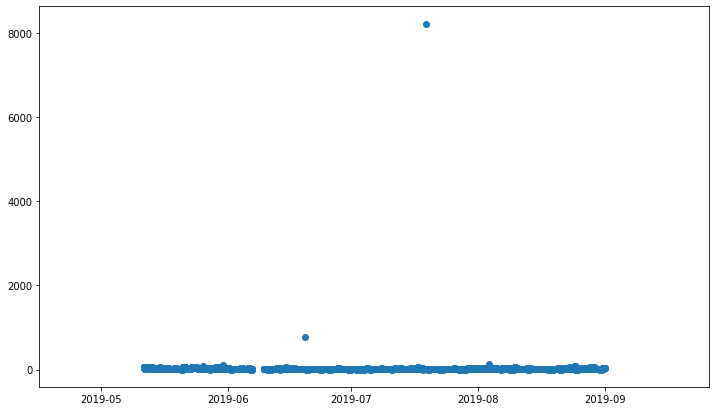

In [13]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.scatter(df['date'], df['pm2.5'])

In [14]:
# Data cleaning
# want_cols = ['humidity', 'pm1.0', 'pm10.0', 'pm2.5', 'temp']
# df = df[(np.abs(stats.zscore(df.loc[:, want_cols])) < 7).all(axis=1)]
df = df.loc[ df['pm2.5'] <= 120 ]
df = df.loc[ df['humidity'] <= 100 ]

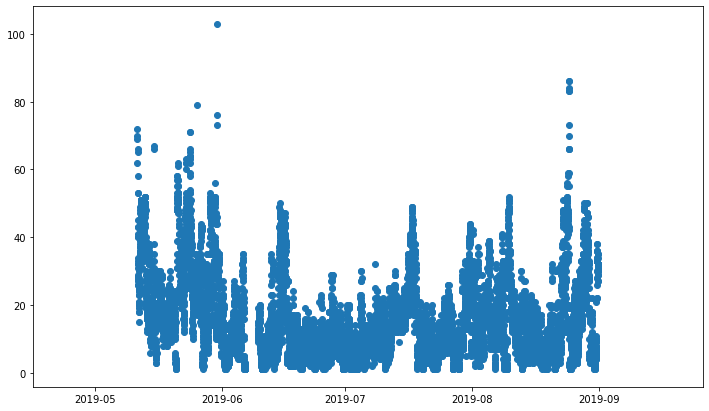

In [15]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.scatter(df['date'], df['pm2.5'])

In [16]:
# Split time infomation from column `date`
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['hour'] = df['date'].apply(lambda x: x.hour)

In [17]:
# Discard some columns
df = df.drop(columns=['date'])

In [18]:
# Evaluate mean values for each hour
dfmean = df.groupby(['month', 'day', 'hour']).mean()

In [19]:
dfmean.head(10)

humidity      pm1.0     pm10.0      pm2.5   temp
month day hour                                                  
5     11  9        67.00  41.666667  81.666667  70.333333  27.00
          10       64.75  37.250000  74.500000  62.750000  27.50
          11       62.50  30.750000  63.000000  48.500000  28.00
          12       60.50  27.000000  50.000000  41.000000  29.00
          13       55.25  20.250000  31.750000  29.000000  30.25
          14       53.50  19.750000  29.750000  28.000000  31.50
          15       53.25  20.750000  34.500000  30.000000  31.75
          16       56.25  22.000000  36.750000  31.500000  30.50
          17       61.00  15.250000  23.750000  22.250000  28.00
          18       64.25  13.000000  21.250000  18.750000  26.25

In [20]:
# Create hourly time
hourly = pd.period_range(start='2019-05-11', end='2019-08-31', freq='H')
hourlydf = pd.DataFrame(hourly, columns=['time'])

In [21]:
# Split time infomation
hourlydf['month'] = hourlydf['time'].apply(lambda x: x.month)
hourlydf['day'] = hourlydf['time'].apply(lambda x: x.day)
hourlydf['hour'] = hourlydf['time'].apply(lambda x: x.hour)
# Set index
hourlydf.set_index(['month', 'day', 'hour'], inplace=True)

In [22]:
# Concat !!!!!!!!
dfconcat = pd.concat([dfmean, wind, rain], axis=1, sort=False)
# Reset index
dfconcat.reset_index(inplace=True)

In [23]:
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

dfconcat['time'] = dfconcat[['month', 'day', 'hour']].apply(get_time, axis=1)

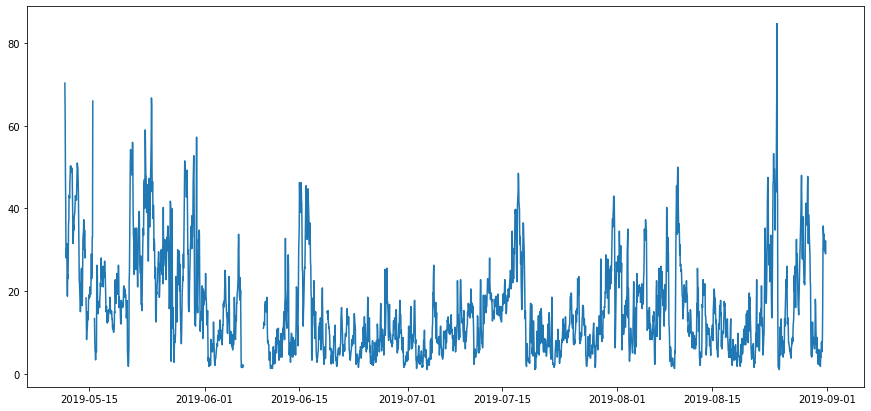

In [24]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(15, 7))
plt.plot(dfconcat['time'], dfconcat['pm2.5'])

#### Add new features

In [25]:
# Shift columns
dfconcat[['pm2.5_shift']] = dfconcat[['pm2.5']].shift(-n)
dfconcat[['time_shift']] = dfconcat[['time']].shift(-n)
dfconcat[['pm2.5_p1']] = dfconcat[['pm2.5']].shift(1)
dfconcat[['pm2.5_p2']] = dfconcat[['pm2.5']].shift(2)
dfconcat[['pm2.5_p3']] = dfconcat[['pm2.5']].shift(3)
dfconcat[['pm2.5_p4']] = dfconcat[['pm2.5']].shift(4)
dfconcat[['pm2.5_p5']] = dfconcat[['pm2.5']].shift(5)
dfconcat[['temp_p1']] = dfconcat[['temp']].shift(1)
dfconcat[['temp_p2']] = dfconcat[['temp']].shift(2)
dfconcat[['temp_p3']] = dfconcat[['temp']].shift(3)
dfconcat[['temp_p4']] = dfconcat[['temp']].shift(4)
dfconcat[['temp_p5']] = dfconcat[['temp']].shift(5)
dfconcat[['humidity_p1']] = dfconcat[['humidity']].shift(1)
dfconcat[['humidity_p2']] = dfconcat[['humidity']].shift(2)
dfconcat[['humidity_p3']] = dfconcat[['humidity']].shift(3)
dfconcat[['humidity_p4']] = dfconcat[['humidity']].shift(4)
dfconcat[['humidity_p5']] = dfconcat[['humidity']].shift(5)
dfconcat[['speed_p1']] = dfconcat[['speed']].shift(1)
dfconcat[['speed_p2']] = dfconcat[['speed']].shift(2)
dfconcat[['speed_p3']] = dfconcat[['speed']].shift(3)
dfconcat[['speed_p4']] = dfconcat[['speed']].shift(4)
dfconcat[['speed_p5']] = dfconcat[['speed']].shift(5)
dfconcat[['rain_p1']] = dfconcat[['rain']].shift(1)
dfconcat[['rain_p2']] = dfconcat[['rain']].shift(2)
dfconcat[['rain_p3']] = dfconcat[['rain']].shift(3)
dfconcat[['rain_p4']] = dfconcat[['rain']].shift(4)
dfconcat[['rain_p5']] = dfconcat[['rain']].shift(5)

In [26]:
# Choose data every 6 row
# dfconcat = dfconcat.loc[ (dfconcat.index % 6) == 0 ]

In [27]:
# Discard rows that contain NaN value
dfconcat.dropna(inplace=True)

In [28]:
dfconcat.shape

(2482, 38)

### Feature Scaling: Normalization

$z = \frac{x- \mu}{\sigma}$


In [29]:
# Save mean and std
feature_cols = ['pm2.5', 'humidity', 'speed', 'rain']
label_cols = ['pm2.5_shift']
want_cols = feature_cols + label_cols

mean_all = dfconcat.loc[:, want_cols].mean()
std_all = dfconcat.loc[:, want_cols].std()
# Normalization
dfconcat.loc[:, want_cols] = (dfconcat.loc[:, want_cols] - mean_all) / std_all

### Divid training set and test set

In [30]:
train_size = len(dfconcat)*0.8
train_size = int(train_size)

In [31]:
train_df = dfconcat[:train_size]
test_df = dfconcat[train_size:]

### Select features

In [32]:
train_X = train_df[feature_cols]
train_y = train_df[label_cols]

In [33]:
test_X = test_df[feature_cols]
test_y = test_df[label_cols]

In [34]:
whole_X = dfconcat[feature_cols]
whole_y = dfconcat[label_cols]

### Fit the model

using `sklearn.linear_model.LinearRegression`

In [35]:
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [36]:
# See the coefficients of our model
for i in range(len(train_X.columns)):
    print('Coefficient for %10s:\t%s' % (train_X.columns[i], model.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])

Coefficient for      pm2.5:	0.9273903898192507
Coefficient for   humidity:	-0.016727376443322273
Coefficient for      speed:	-0.055072374171251506
Coefficient for       rain:	-0.0025807995862302834
Intercept: 			 -0.008021181386772946


In [37]:
# Calculate predict value
predict_train_y = model.predict(train_X)
predict_test_y = model.predict(test_X)

In [38]:
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_test_y_ori = predict_test_y * s + m

train_y_ori = train_y * s + m
predict_train_y_ori = predict_train_y * s + m

# m = mean_all['pm2.5']
# s = std_all['pm2.5']

# test_df_ori = test_df['pm2.5'] * s + m

### Assessing the Fit of the Model

In [39]:
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(train_y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_test_y_ori)

train_mape = mean_absolute_percentage_error(train_y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_test_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))

Train MSE:	 15.087659,	 RMSE: 3.884284 (μg/m^3),	 MAPE:	 24.042193 %
Test MSE:	 19.014034,	 RMSE: 4.360508 (μg/m^3),	 MAPE:	 27.602238 %


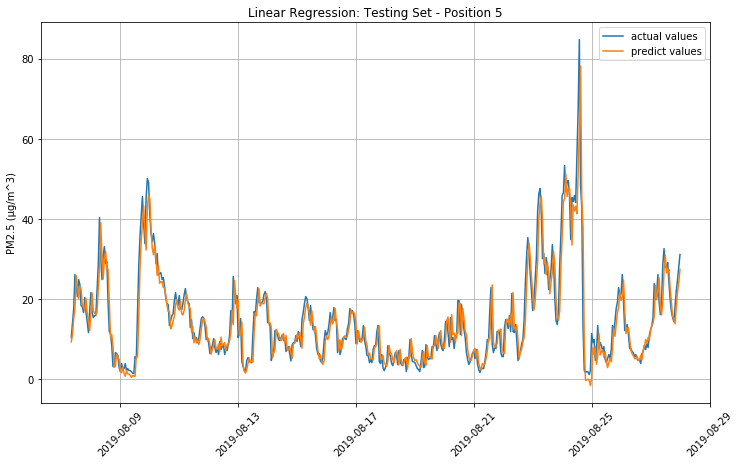

In [40]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_test_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper right')
plt.title('Linear Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()

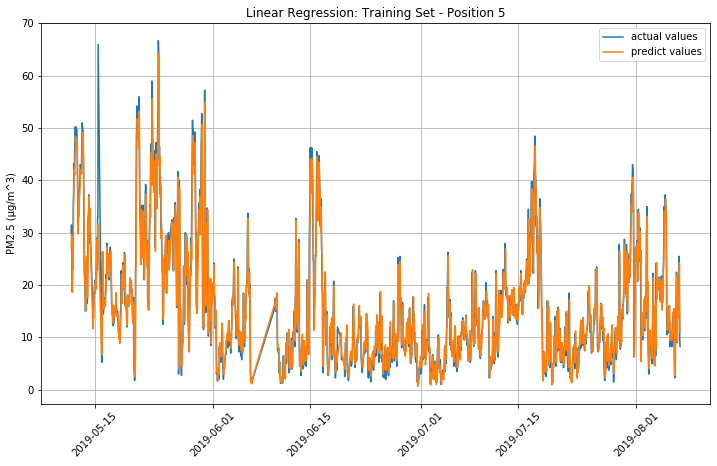

In [41]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(train_df['time_shift'], train_y_ori, label='actual values')
plt.plot(train_df['time_shift'], predict_train_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper right')
plt.title('Linear Regression: Training Set - Position %d' % pos)
plt.grid()
plt.show()

In [42]:
from sklearn.model_selection import learning_curve

def plt_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

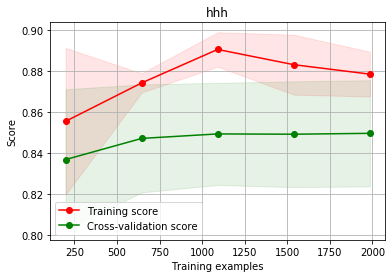

In [43]:
plt_learning_curve(estimator=model, title='hhh', X=whole_X, y=whole_y,
                   ylim=None, cv=5, n_jobs=None)

### Feature Selection via Ridge Regression

~~Our test error is worse than our training error. Therefore, our next job is to improve this.~~

Next, we improve mean squared error. 

We use the class `sklearn.linear_model.Ridge`. We will throw all features in, let ridge regression do selection, and see how our own feature sets compare. Notice we have an additional hyperparameter,  𝛼 . This controls how heavy the penalty is for larger weights.

To perform hyperparameter tuning we can use a technique called **cross validation**. We take our test set, randomly divide into  𝑘  training and testing sets. Differnent samples will be randomly placed in each set, each with their own variance. We then average the results over the folds to estimate how well we will do on unseen test data. After splitting the data into  𝑘  folds (10 is a usual choice for  𝑘 ), we will try out different hyperparameter values and select the best one. Much of this process is already wrapped in `sklearn.model_selection.cross_val_score` for us. We just need to define a scoring function.


In [44]:
# Define a scoring function
def scorer(model, X, y):
    preds = model.predict(X)
    return metrics.mean_squared_error(y, preds)

In [45]:
# Define a range of values for alpha to search over.
alphas = np.linspace(start=0, stop=100, num=11)

mses = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, train_X, train_y, cv=10, scoring=scorer)
    mses.append(mse.mean())

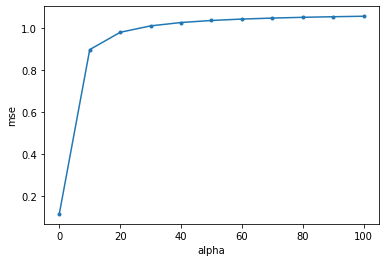

In [46]:
plt.plot(alphas, mses, marker='.')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

In [47]:
best_alpha = alphas[np.argmin(mses)]
best_alpha

0.0

In [48]:
# Use `best_alpha` to fit the model
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(train_X, train_y)

Ridge(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [49]:
# See the coefficients of our model
for i in range(len(train_X.columns)):
    print('Coefficient for %10s:\t%s' % (train_X.columns[i], ridge.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])

Coefficient for      pm2.5:	0.9273903898192485
Coefficient for   humidity:	-0.016727376443325486
Coefficient for      speed:	-0.055072374171254546
Coefficient for       rain:	-0.00258079958622838
Intercept: 			 -0.008021181386772946


In [50]:
# Calculate mean squared error for training set & test set
predict_train_y = ridge.predict(train_X)
predict_test_y = ridge.predict(test_X)

In [51]:
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_test_y_ori = predict_test_y * s + m

train_y_ori = train_y * s + m
predict_train_y_ori = predict_train_y * s + m

# m = mean_all['pm2.5']
# s = std_all['pm2.5']

# test_df_ori = test_df['pm2.5'] * s + m

In [52]:
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(train_y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_test_y_ori)

train_mape = mean_absolute_percentage_error(train_y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_test_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))

Train MSE:	 15.087659,	 RMSE: 3.884284 (μg/m^3),	 MAPE:	 24.042193 %
Test MSE:	 19.014034,	 RMSE: 4.360508 (μg/m^3),	 MAPE:	 27.602238 %


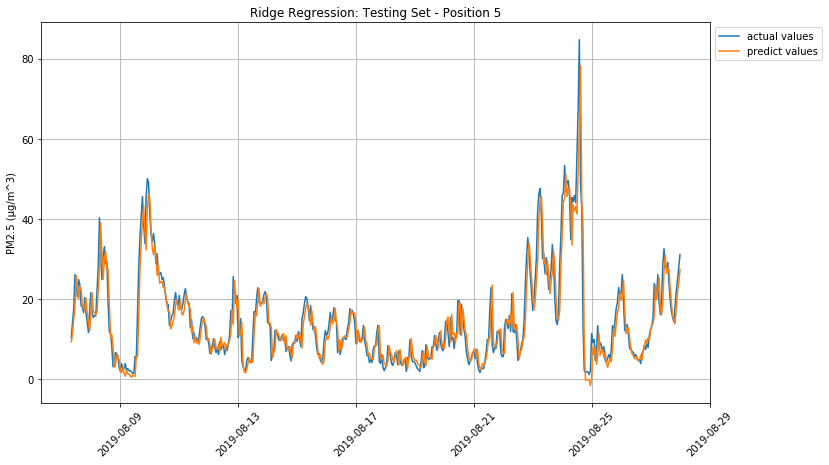

In [53]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_test_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Ridge Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()

## Polynomial Regression

In [63]:
# Load data
n = 1
pos = 3
data3 = get_data_by_pos(pos)
df3 = pd.DataFrame(data3)
# Input time
if pos == 2:
    time = ['2019 06 06', '2020 01 01']
else:
    time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df3 = df3.loc[ df3['date'] >= start_time ]
df3 = df3.loc[ df3['date'] <= end_time ]
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
# Data cleaning
df3 = df3.loc[ df3['pm2.5'] <= 120 ]
df3 = df3.loc[ df3['humidity'] <= 100 ]
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)

In [64]:
df3['ts'] = df3['temp'].apply(lambda x: x**2)
df3['hs'] = df3['humidity'].apply(lambda x: x**2)
wind['ss'] = wind['speed'].apply(lambda x: x**2)
rain['rl'] = rain['rain'].apply(lambda x: np.sqrt(x))

Coefficient for      pm2.5:	0.9110983710590062
Coefficient for         ts:	-0.09250269157572025
Coefficient for         hs:	-0.08745418049347366
Coefficient for      speed:	-0.03873507656646283
Coefficient for         rl:	-0.0038331651533265094
Intercept: 			 -0.005274325203950388
Train MSE:	 15.826336,	 RMSE: 3.978233 (μg/m^3),	 MAPE:	 26.251786 %
Test MSE:	 21.525523,	 RMSE: 4.639561 (μg/m^3),	 MAPE:	 33.145068 %


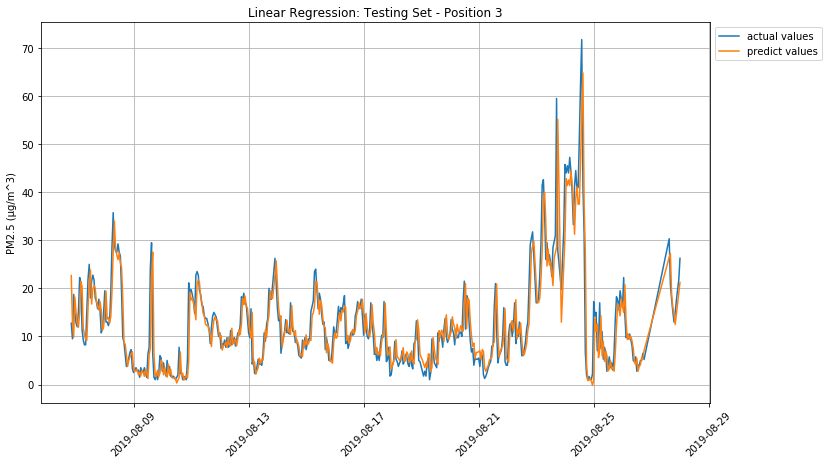

In [65]:
# Discard some columns
df3 = df3.drop(columns=['date'])
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()
# Concat !!!!!!!!
dfconcat = pd.concat([df3mean, wind, rain], axis=1, sort=False)
# Reset index
dfconcat.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

dfconcat['time'] = dfconcat[['month', 'day', 'hour']].apply(get_time, axis=1)
# Shift columns
dfconcat[['pm2.5_shift']] = dfconcat[['pm2.5']].shift(-n)
dfconcat[['time_shift']] = dfconcat[['time']].shift(-n)
# Discard rows that contain NaN value
dfconcat.dropna(inplace=True)
# Save mean and std
feature_cols = ['pm2.5', 'ts', 'hs', 'speed', 'rl']
label_cols = ['pm2.5_shift']
want_cols = feature_cols + label_cols

mean_all = dfconcat.loc[:, want_cols].mean()
std_all = dfconcat.loc[:, want_cols].std()
# Normalization
dfconcat.loc[:, want_cols] = (dfconcat.loc[:, want_cols] - mean_all) / std_all
# Divid training set and test set
four_fifth_len = len(dfconcat)*0.8
four_fifth_len = int(four_fifth_len)

train_df = dfconcat[:four_fifth_len]
test_df = dfconcat[four_fifth_len:]

X = train_df[feature_cols]
y = train_df[label_cols]

test_X = test_df[feature_cols]
test_y = test_df[label_cols]
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])
# Calculate predict value
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

#m = mean_all['pm2.5']
#s = std_all['pm2.5']

#test_df_ori = test_df['pm2.5'] * s + m
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

train_mape = mean_absolute_percentage_error(y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()

## Input all positions data

In [ ]:
for i in range(0, 8):    
    # Load data
    n=1
    pos=i
    data = get_data_by_pos(pos)
    df = pd.DataFrame(data)
    # Input time
    if pos == 2:
        time = ['2019 06 06', '2020 01 01']
    else:
        time = ['2019 05 11', '2020 01 01']
    taipei_tz = pytz.timezone('Asia/Taipei')
    # Set time
    start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
    end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
    # Select the duration
    df = df.loc[ df['date'] >= start_time ]
    df = df.loc[ df['date'] <= end_time ]
    # Rename the names of columns
    df = df.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
    # Data cleaning
    df = df.loc[ df['pm2.5'] <= 120 ]
    df = df.loc[ df['humidity'] <= 100 ]
    # Split time infomation from column `date`
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['hour'] = df['date'].apply(lambda x: x.hour)
    # Discard some columns
    df = df.drop(columns=['date'])
    # Evaluate mean values for each hour
    dfmean = df.groupby(['month', 'day', 'hour']).mean()
    # Concat !!!!!!!!
    dfconcat = pd.concat([dfmean, wind, rain], axis=1, sort=False)
    # Reset index
    dfconcat.reset_index(inplace=True)
    # Reconstruct time infomation by `month`, `day`, and `hour`

    def get_time(x):
        time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
        taipei_tz = pytz.timezone('Asia/Taipei')
        time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
        return time

    dfconcat['time'] = dfconcat[['month', 'day', 'hour']].apply(get_time, axis=1)
    # Add position
    dfconcat['position'] = pos
    # Shift columns
    dfconcat[['pm2.5_shift']] = dfconcat[['pm2.5']].shift(-n)
    dfconcat[['time_shift']] = dfconcat[['time']].shift(-n)
    dfconcat[['pm2.5_p1']] = dfconcat[['pm2.5']].shift(1)
    dfconcat[['pm2.5_p2']] = dfconcat[['pm2.5']].shift(2)
    dfconcat[['pm2.5_p3']] = dfconcat[['pm2.5']].shift(3)
    dfconcat[['pm2.5_p4']] = dfconcat[['pm2.5']].shift(4)
    dfconcat[['pm2.5_p5']] = dfconcat[['pm2.5']].shift(5)
    #
    if i == 0:
        result = dfconcat
    else:
        result = pd.concat([result, dfconcat])

dfconcat = result

In [ ]:
dum = pd.get_dummies(dfconcat['position'], prefix='position')
dfconcat = pd.concat([dfconcat, dum], axis=1, sort=False)

In [ ]:
dfconcat.set_index(['month', 'day', 'hour', 'position'], inplace=True)
dfconcat.reset_index(inplace=True)

In [ ]:
pd.set_option('display.max_columns', None)
dfconcat.tail()

In [ ]:
# Discard rows that contain NaN value
dfconcat.dropna(inplace=True)
# Save mean and std
cat_cols = ['position_0', 'position_1', 'position_2', 'position_3',
            'position_4', 'position_5', 'position_6', 'position_7']
cal_cols = ['pm2.5', 'temp', 'humidity', 'speed', 'rain']
label_cols = ['pm2.5_shift']
feature_cols = cal_cols
want_cols = cal_cols + label_cols

mean_all = dfconcat.loc[:, want_cols].mean()
std_all = dfconcat.loc[:, want_cols].std()
# Normalization
dfconcat.loc[:, want_cols] = (dfconcat.loc[:, want_cols] - mean_all) / std_all
# Divid training set and test set
train_size = len(dfconcat)*0.8
train_size = int(train_size)

train_df = dfconcat[:train_size]
test_df = dfconcat[train_size:]
# Select feature
X = train_df[feature_cols]
y = train_df[label_cols]

test_X = test_df[feature_cols]
test_y = test_df[label_cols]
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])
# Calculate predict value
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

#m = mean_all['pm2.5']
#s = std_all['pm2.5']

#test_df_ori = test_df['pm2.5'] * s + m
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

train_mape = mean_absolute_percentage_error(y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))

In [ ]:
test_df['predict_y_ori'] = predict_y_ori
test_df['test_y_ori'] = test_y_ori
train_df['y_ori'] = y_ori
train_df['predict_train_y_ori'] = predict_train_y_ori

In [ ]:
# Select the duration
pos = 7
test_df3 = test_df.loc[ test_df['position'] == pos ]
train_df3 = train_df.loc[ train_df['position'] == pos ]

In [ ]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df3['time'], test_df_ori, label='actual values')
plt.plot(test_df3['time_shift'], test_df3['test_y_ori'], label='actual values')
plt.plot(test_df3['time_shift'], test_df3['predict_y_ori'], label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()

In [ ]:
# Plt
plt.figure(figsize=(12, 7))
plt.plot(train_df3['time_shift'], train_df3['y_ori'], label='actual values')
plt.plot(train_df3['time_shift'], train_df3['predict_train_y_ori'], label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Training Set - Position %d' % pos)
plt.grid()
plt.show()